# Andrew Whirisky - 17200679 and Neil Jones - 17202155

## Assignment 2 - Part 2 

Train a model to play the Lunar Lander game from OpenAI gym using a convolutional neural network.

In [1]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils
from keras import backend as K

K.set_image_data_format('channels_first')

Using TensorFlow backend.


#### Preparing the Data
Load the raw image dataset and pre-process it. Divide this into train and test splits. Balance the training split.

#### Load Images
Loads a set of images and resizes each image to 64x64 and coverts to black and white.

In [2]:
# Set up some parmaeters for data loading
TRAIN_DIR = "./data" 
sample_rate = 0.1
ROWS = 64
COLS = 64
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    data[i] = image
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

Processed 0 of 6432
Processed 1000 of 6432
Processed 2000 of 6432
Processed 3000 of 6432
Processed 4000 of 6432
Processed 5000 of 6432
Processed 6000 of 6432
Train shape: (6432, 1, 64, 64)


#### Generating the Labels
We're dealing with a multi-class classification problem here - (0) no action, (1) left, (2) up, and (3) right. The lables can be created by looping over the file names in the train directory.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


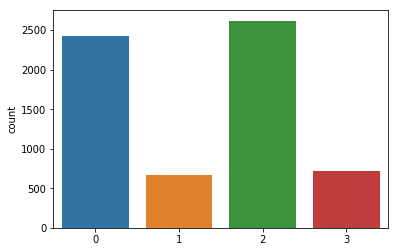

In [3]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
sns.countplot(labels)

#### Partition the dataset for evaluation
Split the data into a training and test partition so we can evaluate at the end

In [4]:
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

Apply under sampling to balance the training dataset

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


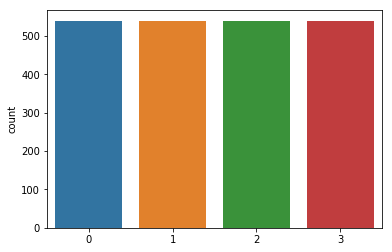

In [5]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

## Build Models 

### A simple MLP network to control the lander.

In [6]:
# reshape dataset to work with the MLP
train_rus_3d = train_rus.reshape((train_rus.shape[0], 64, 64))
test_3d = test.reshape((1287, 64, 64))
train_rus.shape

(2160, 1, 64, 64)

In [7]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(64, 64)))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(num_classes, activation='softmax'))

mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

In [8]:
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Train
Train the model

In [9]:
epochs = 100
batch_size = 128

history = mlp_model.fit(train_rus_3d, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 1620 samples, validate on 540 samples
Epoch 1/100
1620/1620 [==============================] - 3s 2ms/step - loss: 1.5336 - acc: 0.2772 - val_loss: 1.3982 - val_acc: 0.2759
Epoch 2/100
1620/1620 [==============================] - 2s 931us/step - loss: 1.4198 - acc: 0.2673 - val_loss: 1.3796 - val_acc: 0.2889
Epoch 3/100
1620/1620 [==============================] - 2s 944us/step - loss: 1.3957 - acc: 0.2673 - val_loss: 1.3821 - val_acc: 0.2333
Epoch 4/100
1620/1620 [==============================] - 2s 935us/step - loss: 1.3851 - acc: 0.2728 - val_loss: 1.3740 - val_acc: 0.2704
Epoch 5/100
1620/1620 [==============================] - 2s 927us/step - loss: 1.3632 - acc: 0.3198 - val_loss: 1.3441 - val_acc: 0.3296
Epoch 6/100
1620/1620 [==============================] - 1s 922us/step - loss: 1.3587 - acc: 0.3167 - val_loss: 1.3411 - val_acc: 0.3037
Epoch 7/100
1620/1620 [==============================] - 1s 925us/step - loss: 1.3181 - acc: 0.3432 - val_loss: 1.2904 - val_acc: 0.3

Text(0.5,1,'Accuracy Curves')

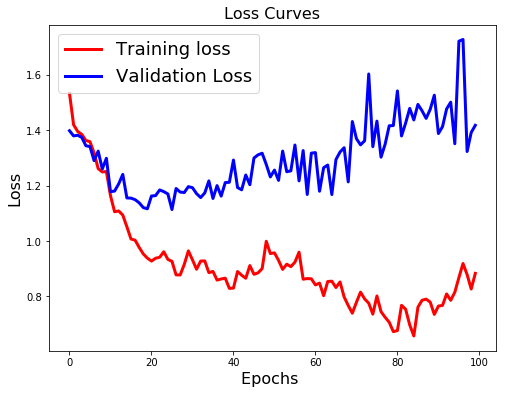

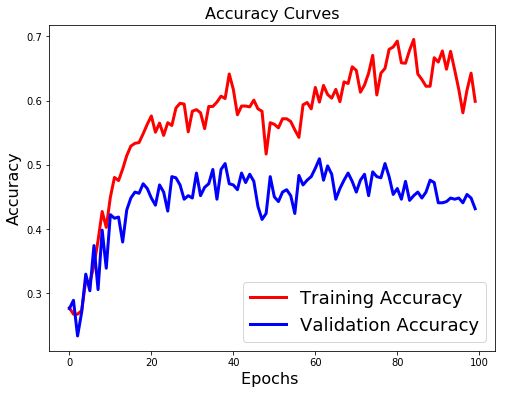

In [10]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)



In [11]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
pred = mlp_model.predict_classes(test_3d)

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

****** Test Data ********
             precision    recall  f1-score   support

          0       0.48      0.09      0.15       480
          1       0.35      0.60      0.44       134
          2       0.46      0.68      0.55       519
          3       0.30      0.39      0.34       154

avg / total       0.44      0.42      0.36      1287

Confusion Matrix
[[ 41  60 323  56]
 [  6  80  39   9]
 [ 34  53 355  77]
 [  4  34  56  60]]


### Simple Convolutional network
A simple convolutional network to control the lander.

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 64, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 516       
Total params: 4,195,268
Trainable params: 4,195,268
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

#### Train
Train the model

In [14]:
epochs = 50
batch_size = 128

history = model.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 1620 samples, validate on 540 samples
Epoch 1/50
1620/1620 [==============================] - 44s 27ms/step - loss: 1.5156 - acc: 0.2481 - val_loss: 1.3781 - val_acc: 0.3444
Epoch 2/50
1620/1620 [==============================] - 43s 27ms/step - loss: 1.3761 - acc: 0.2784 - val_loss: 1.3771 - val_acc: 0.3370
Epoch 3/50
1620/1620 [==============================] - 43s 26ms/step - loss: 1.3734 - acc: 0.2784 - val_loss: 1.3654 - val_acc: 0.3667
Epoch 4/50
1620/1620 [==============================] - 43s 27ms/step - loss: 1.3562 - acc: 0.3117 - val_loss: 1.3548 - val_acc: 0.3593
Epoch 5/50
1620/1620 [==============================] - 43s 27ms/step - loss: 1.3497 - acc: 0.3037 - val_loss: 1.3429 - val_acc: 0.4259
Epoch 6/50
1620/1620 [==============================] - 43s 26ms/step - loss: 1.3264 - acc: 0.3290 - val_loss: 1.3263 - val_acc: 0.4685
Epoch 7/50
1620/1620 [==============================] - 43s 27ms/step - loss: 1.2968 - acc: 0.3809 - val_loss: 1.3096 - val_acc: 0.4389
E

Plot the evolution of the loss as the module was trained.

Text(0.5,1,'Accuracy Curves')

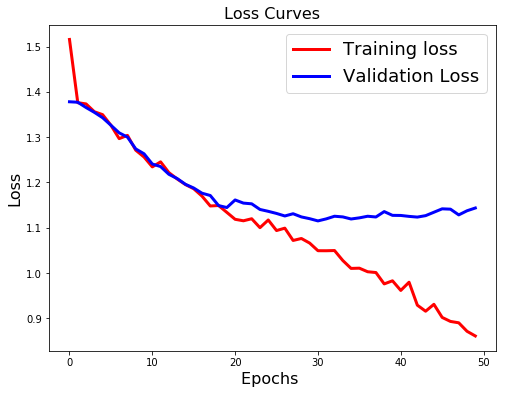

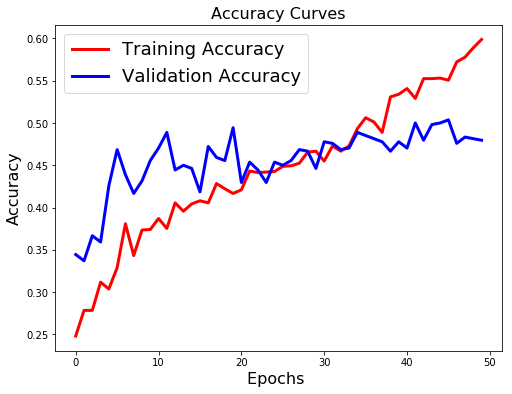

In [15]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Evaluate the Model
Use the test dataset to evaluate the model

In [16]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
pred = model.predict_classes(test)

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

****** Test Data ********
             precision    recall  f1-score   support

          0       0.43      0.54      0.48       480
          1       0.35      0.66      0.46       134
          2       0.46      0.18      0.26       519
          3       0.40      0.60      0.48       154

avg / total       0.43      0.41      0.39      1287

Confusion Matrix
[[257  78  89  56]
 [ 28  89  11   6]
 [274  72  95  78]
 [ 35  17  10  92]]


### CNN based on Atari paper

In [17]:
a_model = Sequential()

#model.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu'))

a_model.add(Conv2D(32,(8, 8), padding='same' , strides=(4, 4), input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
a_model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
a_model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
a_model.add(Flatten())
a_model.add(Dense(512))
a_model.add(Activation('relu'))
a_model.add(Dense(num_classes, activation = 'softmax'))

a_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 16, 16)        2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 7, 7)          32832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 5, 5)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               819712    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 2052      
Total para

In [18]:
a_model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

#### Train
Train the model

In [19]:
epochs = 50
batch_size = 128

history = a_model.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 1620 samples, validate on 540 samples
Epoch 1/50
1620/1620 [==============================] - 7s 4ms/step - loss: 1.3853 - acc: 0.2562 - val_loss: 1.3711 - val_acc: 0.4111
Epoch 2/50
1620/1620 [==============================] - 6s 4ms/step - loss: 1.2962 - acc: 0.4179 - val_loss: 1.2625 - val_acc: 0.4241
Epoch 3/50
1620/1620 [==============================] - 6s 4ms/step - loss: 1.2011 - acc: 0.4272 - val_loss: 1.1856 - val_acc: 0.4241
Epoch 4/50
1620/1620 [==============================] - 6s 4ms/step - loss: 1.1136 - acc: 0.4802 - val_loss: 1.1555 - val_acc: 0.4315
Epoch 5/50
1620/1620 [==============================] - 6s 4ms/step - loss: 1.0724 - acc: 0.4963 - val_loss: 1.1291 - val_acc: 0.4537
Epoch 6/50
1620/1620 [==============================] - 6s 4ms/step - loss: 1.0249 - acc: 0.5204 - val_loss: 1.1075 - val_acc: 0.4611
Epoch 7/50
1620/1620 [==============================] - 6s 4ms/step - loss: 0.9705 - acc: 0.5704 - val_loss: 1.1404 - val_acc: 0.4741
Epoch 8/50
1620

Plot the evolution of the loss as the module was trained.

Text(0.5,1,'Accuracy Curves')

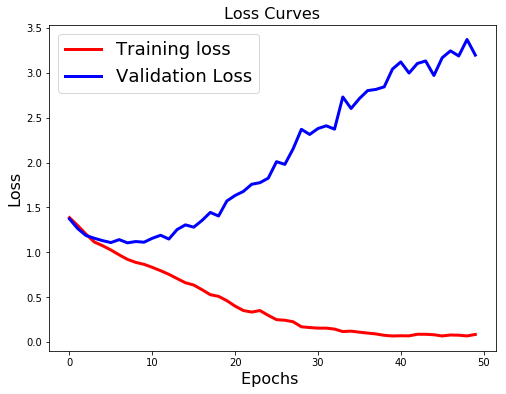

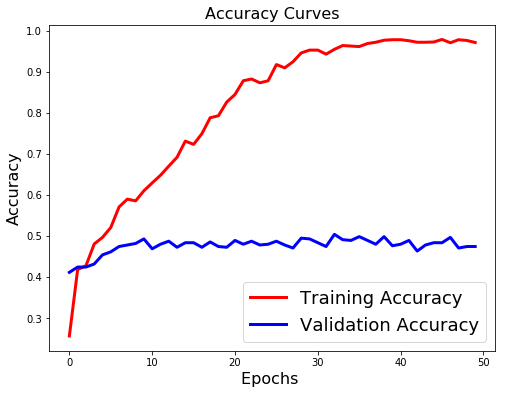

In [20]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Evaluate the Model
Use the test dataset to evaluate the model

In [21]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
pred = a_model.predict_classes(test)

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

****** Test Data ********
             precision    recall  f1-score   support

          0       0.43      0.27      0.33       480
          1       0.28      0.69      0.40       134
          2       0.46      0.27      0.34       519
          3       0.30      0.68      0.41       154

avg / total       0.41      0.36      0.35      1287

Confusion Matrix
[[131 106 130 113]
 [ 16  92  17   9]
 [142 110 139 128]
 [ 16  15  18 105]]


### Deeper CNN

In [22]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(CHANNELS, ROWS, COLS)))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 64, 64)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 62, 62)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 31, 31)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 31, 31)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 31, 31)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 29, 29)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 14, 14)        0         
__________

In [23]:
cnn_model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

In [24]:
epochs = 50
batch_size = 128

history = cnn_model.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Train on 1620 samples, validate on 540 samples
Epoch 1/50
1620/1620 [==============================] - 171s 106ms/step - loss: 1.3846 - acc: 0.2698 - val_loss: 1.3658 - val_acc: 0.3259
Epoch 2/50
1620/1620 [==============================] - 170s 105ms/step - loss: 1.2853 - acc: 0.3938 - val_loss: 1.2287 - val_acc: 0.3944
Epoch 3/50
1620/1620 [==============================] - 170s 105ms/step - loss: 1.1868 - acc: 0.4284 - val_loss: 1.1566 - val_acc: 0.4444
Epoch 4/50
1620/1620 [==============================] - 171s 105ms/step - loss: 1.1423 - acc: 0.4352 - val_loss: 1.1291 - val_acc: 0.4759
Epoch 5/50
1620/1620 [==============================] - 170s 105ms/step - loss: 1.1237 - acc: 0.4352 - val_loss: 1.1395 - val_acc: 0.4204
Epoch 6/50
1620/1620 [==============================] - 170s 105ms/step - loss: 1.0965 - acc: 0.4617 - val_loss: 1.1171 - val_acc: 0.4370
Epoch 7/50
1620/1620 [==============================] - 170s 105ms/step - loss: 1.0935 - acc: 0.4784 - val_loss: 1.1204 - val

Plot the evolution of the loss as the module was trained.

Text(0.5,1,'Accuracy Curves')

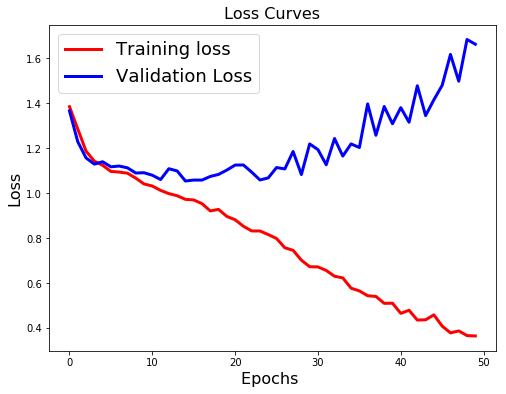

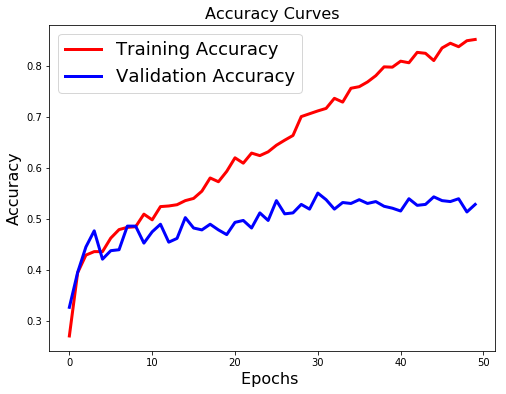

In [25]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#### Evaluate the Model
Use the test dataset to evaluate the model

In [26]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
pred = cnn_model.predict_classes(test)

# Print performance details
print(metrics.classification_report(test_labels, pred))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))
#display(pd.crosstab(test_labels, list(pred), margins=True))

****** Test Data ********
             precision    recall  f1-score   support

          0       0.47      0.56      0.51       480
          1       0.43      0.64      0.52       134
          2       0.57      0.29      0.39       519
          3       0.40      0.65      0.50       154

avg / total       0.50      0.47      0.46      1287

Confusion Matrix
[[270  49  97  64]
 [ 31  86   9   8]
 [233  57 152  77]
 [ 37   6  11 100]]


### Save the best model

When taking the validation loss into consideration it is evident that the last model we tested has performed the best with a much lower validation loss then the architecture recommended from the Atari paper. 

The final model also received a greater F1 score then the Atari CNN.( 46 v 35)

All models the seem to overfit as the epochs increase. I tried implementing dropouts in the last CNN we tested but it did seem to reduce the overfitting.  

The model starts overfitting at around 10 epochs as the validation accuracy does not increase after that point. Next time it might be best to just train the model for 10 epochs as there is no performance gains after that point and the model just overfits.


Persist the best performing model 

In [27]:
# Persist model 
filepath = "best_cnn.mod"
cnn_model.save(filepath)

Persist the Atari model

In [28]:
# Persist model 
filepath = "atari_cnn.mod"
a_model.save(filepath)